<a href="https://colab.research.google.com/github/MCalenda/Q-DELOREAN/blob/main/notebooks/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN


## Import Libraries and Frameworks

In [ ]:
!pip install nlpaug

import re
import string

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nlpaug.augmenter.word as naw
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data

In [ ]:
SEED = 42

DATASET_PATH = 'data/interim/promise-reclass_filtered.csv'
DATASET_FOLDER_PATH = 'data/processed/'

df = pd.read_csv(DATASET_PATH)

## Feature selection and engineering

In [ ]:
to_drop_columns = ['ProjectID', 'IsFunctional', 'IsQuality']

df = df.drop(to_drop_columns, axis=1)

In [ ]:
X_column = 'RequirementText'
y_column = 'Class'

to_update_classes = {'US', 'SE', 'O', 'PE', 'LF', 'SC', 'A', 'MN', 'L', 'FT', 'PO'}
df[y_column] = df[y_column].replace(to_update_classes, 'NF')

### Balance data

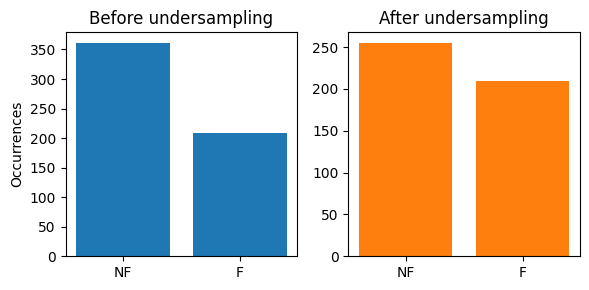

In [ ]:

from imblearn.under_sampling import RandomUnderSampler

X = df[X_column]
y = df[y_column]
class_counts = y.value_counts()

X_arr = X.to_numpy()
y_arr = y.to_numpy()

rus = RandomUnderSampler(sampling_strategy=0.818, random_state=SEED)
X_resampled, y_resampled = rus.fit_resample(X_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
df_resampled = pd.DataFrame({X_column: X_resampled.flatten(), y_column: y_resampled.flatten()})
new_class_counts = df_resampled[y_column].value_counts()

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].bar(class_counts.index, class_counts, color=next(colours))
axs[0].set_ylabel('Occurrences')
axs[0].set_title('Before undersampling')

axs[1].bar(new_class_counts.index, new_class_counts.values, color=next(colours))
axs[1].set_title('After undersampling')

plt.tight_layout()
plt.show()

### Text Normalization

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def normalize_text(text):
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # tokenization
    tokens = word_tokenize(text)

    # # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # # remove digit
    tokens = [token for token in tokens if not token.isdigit()]

    # # remove token with length <= 2
    tokens = [token for token in tokens if len(token) > 2]

    return " ".join(tokens)

df_normalized = df_resampled.copy()
df_normalized[X_column] = df_normalized[X_column].apply(normalize_text)

## Save data

In [ ]:
df_resampled.to_csv(DATASET_FOLDER_PATH + 'promise-reclass_resampled.csv', index=False)
df_normalized.to_csv(DATASET_FOLDER_PATH + 'promise-reclass_normalized.csv', index=False)